# Lab: SVMs on Extended MNIST

In the demo for this unit, we saw how SVMs can be used for the classic problem of MNIST digit recognition. In this lab, we are going to extend the MNIST dataset by adding a number of non-digit letters and see if the classifier can distinguish the digits from the non-digits. All non-digits will be lumped as a single 11-th class. This is a highly simplified version of a 'detection' problem (as opposed to 'classification' problem). Detection is vital in OCR and related problems since the non useful characters must be rejected. 

In addition to the concepts in the demo, you will learn:
* Combine multiple datasets
* Select the SVM parameters (`C` and `gamma`) via cross-validation.
* Use the `GridSearchCV` method to search for parameters with cross-validation.


As usual, we download the standard packages

In [176]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

## About NIST, National Institute of Standards and Technology
NIST is an agency of the United States Department of Commerce that promotes innovation and industrial competitiveness by advancing measurement science, standards, and technology. NIST also develops cybersecurity resources for various sectors and applications.

## Downloading the EMNIST Dataset

After creating the highly popular MNIST dataset, NIST created an extended version of the dataset that includes letters and digits.
The extended datbase (called EMNIST) also has many more examples per class.  

To download the data, go to the [EMNIST webpage](https://www.nist.gov/itl/iad/image-group/emnist-dataset).  Near the bottom, you will see a link for `MATLAB format dataset`.  If you click on this link, you will download a `zip` file with several datasets in it.  The total file is 726M, so it may take some time and diskspace to download.  Extract two files:
* `emnist-digits.mat`:  This is a file of digits `0` to `9`, but with more examples per class.
* `emnist-letters.mat`:  This is a file of letters `a/A` to `z/Z`.  The lower and upper case letters are grouped into the same class.

Once you get these two files, you can save yourself the diskspace and remove all the other files.

In [177]:
# TODO:  Download emnist-letters.mat and emnist-digits.mat to the working directory

Since MATLAB files are still widely-used, Python has excellent routines for loading MATLAB files.  The function below uses the `scipy.io` package to extract the relevant fields from the MATLAB file.  Specifically, the function extracts the training and test data from MATLAB file. 

In [178]:
import scipy.io
def load_emnist(file_path='emnist-digits.mat'):
    """
    Loads training and test data with ntr and nts training and test samples
    The `file_path` is the location of the `eminst-balanced.mat`.
    """    
    
    # Load the MATLAB file
    mat = scipy.io.loadmat(file_path)
    
    # Get the training data
    Xtr = mat['dataset'][0][0][0][0][0][0][:]
    ntr = Xtr.shape[0]
    ytr = mat['dataset'][0][0][0][0][0][1][:].reshape(ntr).astype(int)
    
    # Get the test data
    Xts = mat['dataset'][0][0][1][0][0][0][:]
    nts = Xts.shape[0]
    yts = mat['dataset'][0][0][1][0][0][1][:].reshape(nts).astype(int)
    
    print("%d training samples, %d test samples loaded" % (ntr, nts))

    return [Xtr, Xts, ytr, yts]

Use the function above to get all the digit images from the `emnist-digits.mat` file.  

In [179]:
# TODO:  Load the digit data from emnist-digits.mat
Xtr_dig, Xts_dig, ytr_dig, yts_dig = load_emnist('emnist-digits.mat')


240000 training samples, 40000 test samples loaded


You should see 240000 training samples and 40000 test samples.  Now use the same function to get the letter characters from `emnist-letters.mat`.  

In [180]:
# TODO:  Load the digit data from emnist-letters.mat
Xtr_let, Xts_let, ytr_let, yts_let = load_emnist('emnist-letters.mat')


124800 training samples, 20800 test samples loaded


You should see 124800 training samples and 20800 test samples.  Next, will recreate the `plt_digit` function from the demo.

In [181]:
def plt_digit(x,y=None):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq.T,  cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])    
    if y != None:
        plt.title('%d' % y)        

Plot 8 random samples from the training data.  You can use the `plt_digit` function above with `subplot` to create a nice display.  I suggest sizing your plots using the `plt.figure(figsize=(10,20))` command.

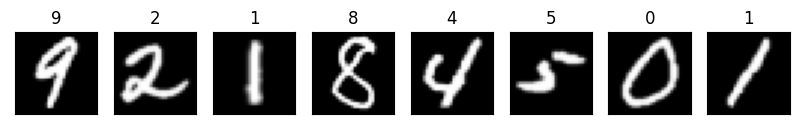

In [182]:
# TODO:  Plot 8 random samples from the training data of the digits
X = Xtr_dig
y = ytr_dig

# Select random digits
nplt = 8
nsamp = X.shape[0]
Iperm = np.random.permutation(nsamp)

# Plot the images using the subplot command
plt.figure(figsize=(10,20))
for i in range(nplt):
    ind = Iperm[i]
    plt.subplot(1,nplt,i+1)
    plt_digit(X[ind,:], y[ind])   


Next, plot 8 random samples from the letters training data.  You should see that the labels go from 1 to 26, corresponding to `a` to `z`.  Upper and lower case letters belong to the same class.

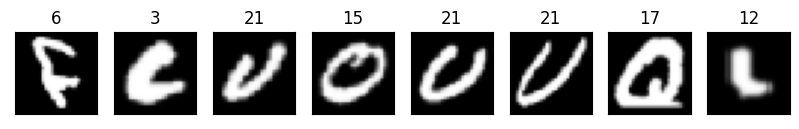

In [183]:
# TODO:  Plot 8 random samples from the training data of the letters
X = Xtr_let
y = ytr_let

# Select random digits
nplt = 8
nsamp = X.shape[0]
Iperm = np.random.permutation(nsamp)

# Plot the images using the subplot command
plt.figure(figsize=(10,20))
for i in range(nplt):
    ind = Iperm[i]
    plt.subplot(1,nplt,i+1)
    plt_digit(X[ind,:], y[ind]) 

## Creating a Non-Digit Class

SVM classifiers are very slow to train.  The training is particularly slow when there are a large number of classes.  To speed things up, we are going to put all of the letters in one class and merge that class with the digits data.  

Before we begin, we will remove all the samples corresponding to `i/I`, `l/L` and `o/O`, since otherwise these letters would get confused with the digits `0` and `1`.  Create arrays `Xtr_let_rem` and `ytr_let_rem` from the data `Xtr_let` and `ytr_let`, where the samples `i` with `ytr_let[i] == 9, 12, 15` are removed.   Create `Xts_let_rem` and `yts_let_rem` similarly.

If you are clever, you can do this without a for-loop via python broadcasting and `np.all(..., axis=1)` command.  But, if you like, you can use a for-loop.

In [184]:
remove_list = np.array([9,12,15])

# TODO:  Create arrays with labels 9, 12 and 15 removed
remove_list = [9,12,15]
for i in range(len(remove_list)):
    Xtr_let_rem = Xtr_let[ytr_let != remove_list[i]]
    ytr_let_rem = ytr_let[ytr_let != remove_list[i]]
    Xts_let_rem = Xts_let[yts_let != remove_list[i]]
    yts_let_rem = yts_let[yts_let != remove_list[i]]

#the shapes of the arrays
print(Xtr_let_rem.shape)
print(ytr_let_rem.shape)
print(Xts_let_rem.shape)
print(yts_let_rem.shape)


(120000, 784)
(120000,)
(20000, 784)
(20000,)


To speed things up even further, we will use only a small subset of the training and test data.  Of course, we will not get great results with this small dataset.  But we can still illustrate the basic concepts.  

Create training arrays `Xtr1_dig` and `ytr1_dig` by selecting 5000 random samples from `Xtr_dig` and `ytr_dig`.  Then create training arrays `Xtr1_let` and `ytr1_let` by selecting 1000 random samples from `Xtr_let_rem` and `ytr_let_rem`.  Similarly, create test arrays `Xts1_dig,Xts1_let,yts1_dig,yts1_let` with 5000 digits and 1000 letters.

In [185]:
import numpy as np

# Number of training and test digits and letters
ntr_dig = 5000
ntr_let = 1000
nts_dig = 5000
nts_let = 1000

# Create training arrays Xtr1_dig and ytr1_dig
idx_tr_dig = np.random.choice(len(Xtr_dig), size=ntr_dig, replace=False)
Xtr1_dig = Xtr_dig[idx_tr_dig,:]
ytr1_dig = ytr_dig[idx_tr_dig]

# Create training arrays Xtr1_let and ytr1_let
idx_tr_let = np.random.choice(len(Xtr_let_rem), size=ntr_let, replace=False)
Xtr1_let = Xtr_let_rem[idx_tr_let,:]
ytr1_let = ytr_let_rem[idx_tr_let]

# Create test arrays Xts1_dig, Xts1_let, yts1_dig, yts1_let
idx_ts_dig = np.random.choice(len(Xts_dig), size=nts_dig, replace=False)
Xts1_dig = Xts_dig[idx_ts_dig,:]
yts1_dig = yts_dig[idx_ts_dig]

idx_ts_let = np.random.choice(len(Xts_let), size=nts_let, replace=False)
Xts1_let = Xts_let[idx_ts_let,:]
yts1_let = yts_let[idx_ts_let]




Now we will merge our digit and letter training arrays.
* Create an array `Xtr` by stacking `Xtr1_dig`, `Xtr1_let`.  This should result in 6000 total samples.
* Create a new label vector `ytr` where `ytr[i] = ytr1_dig[i]` for any digit sample and `ytr[i]=10` for any letter sample.  Thus, all the letters are lumped into the single class with label 10.

Create test arrays `Xts` and `yts` similarly. 

You may wish to use the `np.hstack` and `np.vstack` methods.

In [186]:
# create a vector of ones that is the same length as the letters sample
tens = 10.0*np.ones(len(ytr1_let))

# Create an array `Xtr` by stacking `Xtr1_dig`, `Xtr1_let
Xtr = np.vstack((Xtr1_dig, Xtr1_let))
ytr = np.hstack((ytr1_dig, tens))

print(Xtr.shape)
print(ytr.shape)
Xts, yts = np.vstack((Xts1_dig, Xts1_let)), np.hstack((yts1_dig, tens))
print(Xts.shape)
print(yts.shape)


(6000, 784)
(6000,)
(6000, 784)
(6000,)


Checking the validity of the transforms 

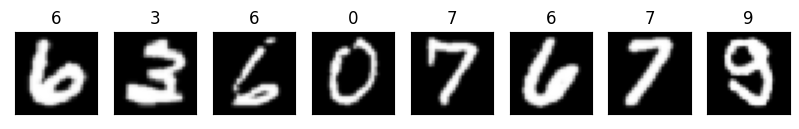

In [187]:
X = Xtr
y = ytr

# Select random digits
nplt = 8
nsamp = X.shape[0]
Iperm = np.random.permutation(nsamp)

# Plot the images using the subplot command
plt.figure(figsize=(10,20))
for i in range(nplt):
    ind = Iperm[i]
    plt.subplot(1,nplt,i+1)
    plt_digit(X[ind,:], y[ind]) 

The features above use pixel values from 0 to 255.  Let's rescale the pixels to the interval from -1.0 to 1.0.  This will yield slightly better performance.  We'll put the scaled data into arrays `Xtr1` and `Xts1`. Note that the pixel data is 8-bit integer, so be careful not to use 8-bit multiplications like `2*Xtr` because they will overflow.

In [188]:
# Rescale the data to the interval from -1.0 to 1.0
Xtr1 = (Xtr / 127.5) - 1.0 # the .0 is necessary
Xts1 = (Xts / 127.5) - 1.0

# the min and max values of the rescaled data
print(Xtr1.min())
print(Xtr1.max())

# the mind and max of the test data
print(Xts1.min())
print(Xts1.max())



-1.0
1.0
-1.0
1.0


Checking the validity once again

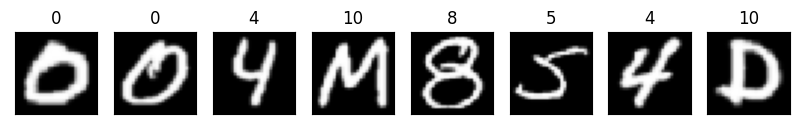

In [189]:
X = Xtr1
y = ytr

# Select random digits
nplt = 8
nsamp = X.shape[0]
Iperm = np.random.permutation(nsamp)

# Plot the images using the subplot command
plt.figure(figsize=(10,20))
for i in range(nplt):
    ind = Iperm[i]
    plt.subplot(1,nplt,i+1)
    plt_digit(X[ind,:], y[ind]) 

## The SVM classifier

Let's first create an SVM classifer with penalty `C=2.8` and an `rbf` kernel of width `gamma=.0073`. We will reexamine these choices later.

In [201]:
from sklearn import svm

# Create a classifier: a support vector classifier with RBF kernel
svm = svm.SVC(probability=False, kernel="rbf", C=2.8, gamma=.0073, verbose=1)


Now we fit the classifier using the scaled training data.  Although SVMs are slow to train, we have kept the training set small, so the fitting should take less than a minute.

In [202]:
svm.fit(Xtr1,ytr)


[LibSVM]*
optimization finished, #iter = 367
obj = -23.854850, rho = -0.592451
nSV = 195, nBSV = 0
*
optimization finished, #iter = 773
obj = -70.286065, rho = 0.230247
nSV = 427, nBSV = 0
*
optimization finished, #iter = 612
obj = -54.876902, rho = 0.007415
nSV = 350, nBSV = 0
*
optimization finished, #iter = 631
obj = -50.593015, rho = 0.047645
nSV = 361, nBSV = 0
*
optimization finished, #iter = 753
obj = -71.322714, rho = 0.160867
nSV = 416, nBSV = 0
*
optimization finished, #iter = 735
obj = -67.857883, rho = -0.073742
nSV = 382, nBSV = 0
*
optimization finished, #iter = 516
obj = -41.233593, rho = -0.149607
nSV = 295, nBSV = 0
*
optimization finished, #iter = 665
obj = -63.254172, rho = 0.174493
nSV = 380, nBSV = 0
*
optimization finished, #iter = 552
obj = -46.134477, rho = -0.076823
nSV = 319, nBSV = 0
*.*
optimization finished, #iter = 1261
obj = -155.392509, rho = 0.803517
nSV = 668, nBSV = 2
*
optimization finished, #iter = 467
obj = -35.977712, rho = 0.834352
nSV = 241, nBS

SVC(C=2.8, gamma=0.0073, verbose=1)

Now let's compute and print the accuracy on the test data.  This too should take less than a minute.  You should get an accuracy of around 89%.

In [203]:
# TODO:  Measure error on the test data
yhat_ts = svm.predict(Xts1)
acc = np.mean(yhat_ts == yts)

In [204]:
print('Accuracy = {0:f}'.format(acc))

Accuracy = 0.903667


The accuracy is bit lower than what we would get with digits only.  This is because the "letters" class is extremely complex.  

To see this, print and then plot the normalized confusion matrix.  You should see that the error rate on the "letters" class is much higher than the others.

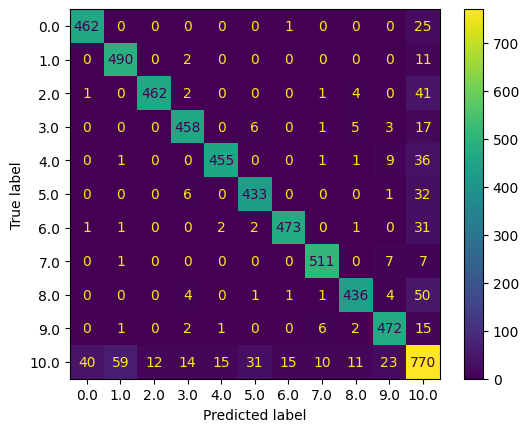

In [205]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# TODO:  Print and plot the normalized confusion matrix
cm = confusion_matrix(yts, yhat_ts)
# plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()

Print the following:
* the fraction of digits that are mislabeled as letters  
* the fraction of letters that are mislabeled as digits

In [255]:
# the total of each row in the confusion matrix
totalRow = np.sum(cm, axis=1)

# the total of each column in the confusion matrix
totalCol = np.sum(cm, axis=0)

totalDigits = np.sum(totalRow[0:9])
totalLetters = np.sum(totalRow[10:])

# the diagonal elements are the correct predictions
correct = cm.diagonal()

correctDigits = np.sum(correct[0:9])
correctLetters = np.sum(correct[10:])

digitErrorRate = (totalDigits-correctDigits)/totalDigits
letterErrorRate = (totalLetters-correctLetters)/totalLetters

print('Digit error rate = ',digitErrorRate)
print('Letter error rate = ',letterErrorRate)



Digit error rate =  0.0713174850033326
Letter error rate =  0.23


## Optimizing gamma and C via Cross-Validation

Above, and in the demo, we used externally provided `gamma` and `C` values.  In general, these parameters should be carefully chosen.  We will now choose these parameters via cross validation using sklearn's `GridSearchCV` method.

Ideally, we would try many more values for each of the parameters, but this would take a long time.  So, we will try only 3 values for each.  Still, this will take several minutes to complete. 

The `GridSearchCV` method does a train-test split in addition to the parameter search.  In this case, we already have a train-test split, and so we will first combine the train and test data back into a single dataset to use with `GridSearchCV`.

Create arrays `X` and `y` from `Xtr1`, `Xts1`, `ytr` and `yts`.  Use `np.vstack` and `np.hstack`.

In [208]:
# TODO:  Create combined trained and test data X and y.
X = np.vstack((Xtr1, Xts1))
y = np.hstack((ytr, yts))


Normally, `GridSearchCV` will do $K$-fold validation and automatically split the data into training and test in each fold.  But, in this case, we want it to use only one fold with a specific train-test split.  To do this, we can do the following:
* Create a vector `test_fold` where `test_fold[i] = -1` for the samples `i` in the training data (which indicates that they should not be used as test data in any fold) and `test_fold[i] = 0` for the samples `i` in the test data (which indicates that they should be used as test data in fold 0).
* Run `ps = sklearn.model_selection.PredefinedSplit(test_fold)` to create a predefined test-split object.

In [217]:
# TODO:  Create a pre-defined test split object 
import sklearn.model_selection

# test_fold is -1 for samples in the training set and 0 for samples in the test set
n_ones = -1*np.ones(len(ytr))
print('The shape of n_ones is {0}'.format(n_ones.shape))
zeros = np.zeros(len(yts))
print('The shape of zeros is {0}'.format(zeros.shape))
test_fold = np.hstack((n_ones, zeros))
# print the shape min and max, and mean of test_fold
print('The mean of test_fold is {0:f}'.format(np.mean(test_fold)))
print('The min of test_fold is {0:f}'.format(np.min(test_fold)))
print('The max of test_fold is {0:f}'.format(np.max(test_fold)))
print('The shape of test_fold is {0}'.format(test_fold.shape))

ps = sklearn.model_selection.PredefinedSplit(test_fold)


The shape of n_ones is (6000,)
The shape of zeros is (6000,)
The mean of test_fold is -0.500000
The min of test_fold is -1.000000
The max of test_fold is 0.000000
The shape of test_fold is (12000,)


Now we are ready to run `GridSearchCV` and call it's `fit` method. Call `GridSearchCV` using `cv=ps` to use our test-split object. Also, use `verbose=10` to have it show progress during fitting.

In [219]:
from sklearn.model_selection import GridSearchCV
# TODO:  Create a GridSearchCV classifier
C_test = [0.1, 1, 10]
gam_test = [0.001, 0.01, 0.1]
clf = GridSearchCV(svm, param_grid={'C': C_test, 'gamma': gam_test}, cv=ps, verbose=10)

# fit the classifier
clf.fit(X, y)


Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV 1/1; 1/9] START C=0.1, gamma=0.001..........................................
[LibSVM]*
optimization finished, #iter = 134
obj = -13.882104, rho = -0.574439
nSV = 231, nBSV = 215
*
optimization finished, #iter = 281
obj = -32.522191, rho = 0.214959
nSV = 494, nBSV = 467
*
optimization finished, #iter = 245
obj = -26.258757, rho = -0.114341
nSV = 417, nBSV = 390
*
optimization finished, #iter = 201
obj = -21.736503, rho = 0.071431
nSV = 353, nBSV = 331
*
optimization finished, #iter = 300
obj = -35.060038, rho = 0.271560
nSV = 524, nBSV = 501
*
optimization finished, #iter = 283
obj = -31.930780, rho = -0.084490
nSV = 490, nBSV = 467
*
optimization finished, #iter = 190
obj = -20.878741, rho = -0.199816
nSV = 340, nBSV = 323
*
optimization finished, #iter = 234
obj = -25.852049, rho = 0.121102
nSV = 405, nBSV = 381
*
optimization finished, #iter = 190
obj = -20.870757, rho = -0.106100
nSV = 333, nBSV = 316
*
optimization fini

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=SVC(C=2.8, gamma=0.0073, verbose=1),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1]},
             verbose=10)

Print the `best_score_` and `best_params_` attributes of the classifier to find the best score and parameters

In [220]:
# Print the best parameter and score of the classifier
print('The best parameter is {0}'.format(clf.best_params_))
print('The best score is {0:f}'.format(clf.best_score_))




The best parameter is {'C': 10, 'gamma': 0.001}
The best score is 0.896000


Finally, print the CV test scores from `cv_results_['mean_test_score']`.

In [221]:
# Print the mean test score for each parameter value.
print('The mean test score for each parameter value is {0}'.format(clf.cv_results_['mean_test_score']))


The mean test score for each parameter value is [0.7815     0.599      0.16666667 0.86016667 0.88666667 0.20966667
 0.896      0.8905     0.21266667]


## Citations

Cohen, G., Afshar, S., Tapson, J., & van Schaik, A. (2017). EMNIST: an extension of MNIST to handwritten letters. Retrieved from http://arxiv.org/abs/1702.05373